Problem Understanding:

In [2]:
# Step 1: Problem Understanding

# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/onlinefraud.csv")

# Basic information about the dataset
print("Dataset Information:")
print(df.info())

# Shape of the dataset
print("\nDataset Shape:", df.shape)

# Display the first few rows
print("\nSample Data:")
print(df.head())

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Distribution of the target variable
print("\nTarget Variable Distribution (isFraud):")
print(df['isFraud'].value_counts())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531542 entries, 0 to 531541
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            531542 non-null  int64  
 1   type            531542 non-null  object 
 2   amount          531542 non-null  float64
 3   nameOrig        531541 non-null  object 
 4   oldbalanceOrg   531541 non-null  float64
 5   newbalanceOrig  531541 non-null  float64
 6   nameDest        531541 non-null  object 
 7   oldbalanceDest  531541 non-null  float64
 8   newbalanceDest  531541 non-null  float64
 9   isFraud         531541 non-null  float64
 10  isFlaggedFraud  531541 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 44.6+ MB
None

Dataset Shape: (531542, 11)

Sample Data:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1  

Step 2: Data Preparation

In [3]:
# Handle Missing Data
# Fill missing values in numeric columns with 0
df.fillna(0, inplace=True)

In [4]:
# Feature Engineering: Encode Categorical Variables
# One-hot encode the 'type' column
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [5]:
# Drop irrelevant columns: 'nameOrig' and 'nameDest' (not useful for modeling)
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


In [6]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling to relevant numeric columns
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [7]:
# Split Features (X) and Target (y)
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # Features
y = df['isFraud']  # Target variable

Step 3: EDA

Fraud Distribution in the Dataset:


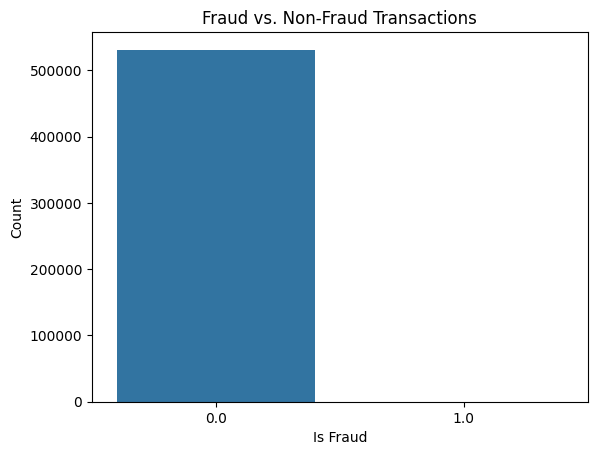

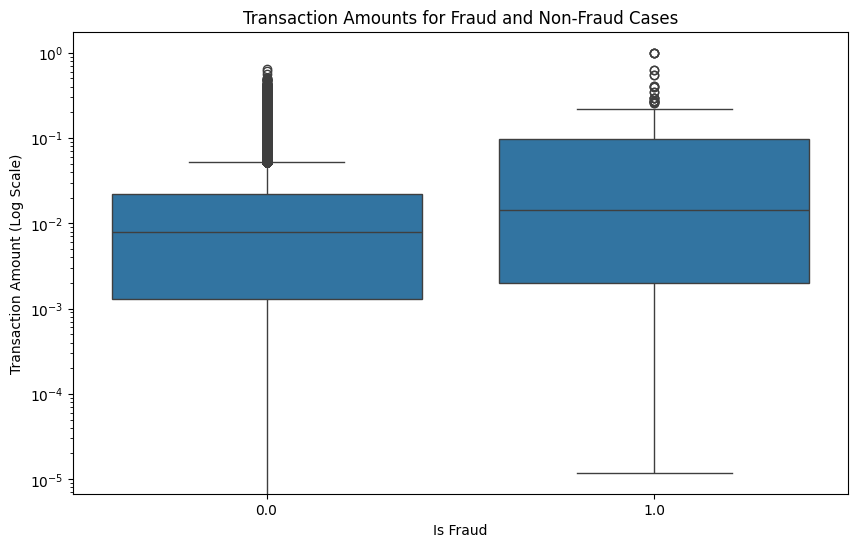

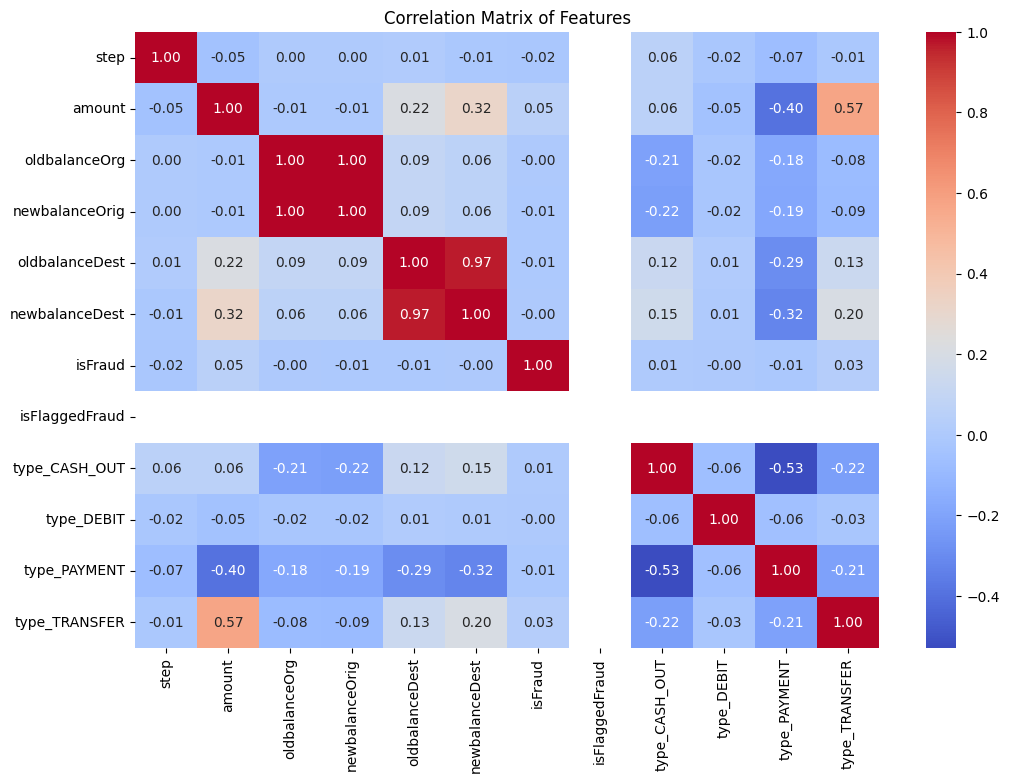

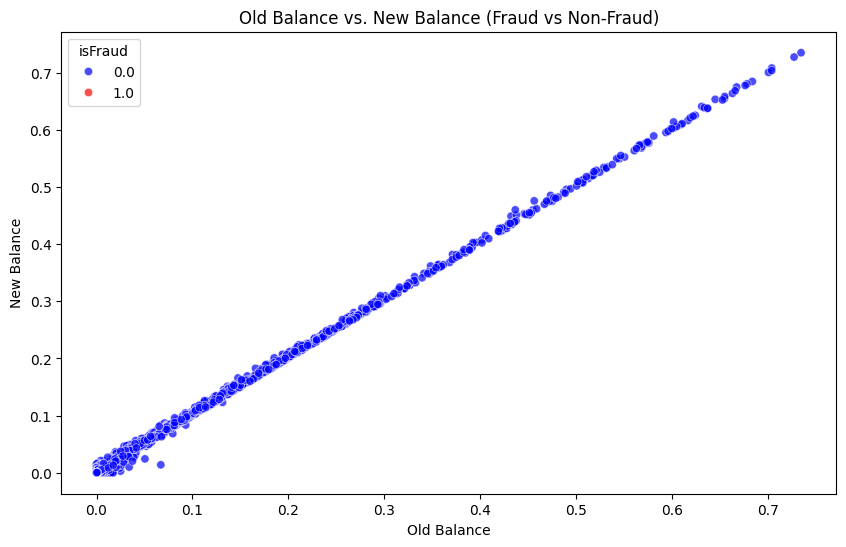


Transaction Types Distribution:


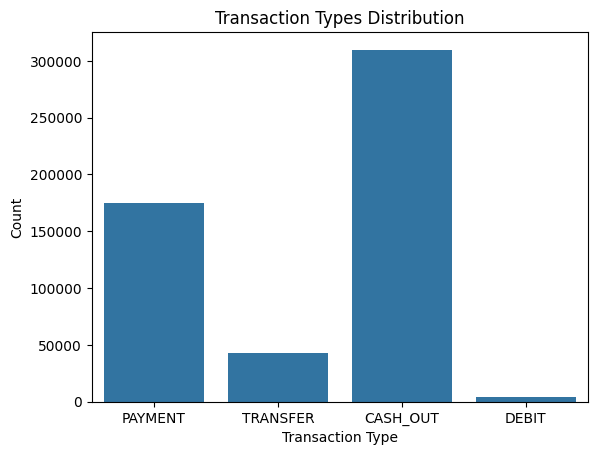

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Analyze Basic Statistics and Target Distribution
print("Fraud Distribution in the Dataset:")
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs. Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# 2. Transaction Amount Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amounts for Fraud and Non-Fraud Cases')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount (Log Scale)')
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Features')
plt.show()

df_sample = df.sample(n=10000, random_state=42)

# Generate scatter plot with the sample
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='oldbalanceOrg',
    y='newbalanceOrig',
    hue='isFraud',
    alpha=0.7,
    palette={0: 'blue', 1: 'red'},
    data=df_sample
)
plt.title('Old Balance vs. New Balance (Fraud vs Non-Fraud)')
plt.xlabel('Old Balance')
plt.ylabel('New Balance')
plt.show()
# 5. Distribution of Transaction Types
type_columns = [col for col in df.columns if col.startswith('type_')]
df['type_reconstructed'] = df[type_columns].idxmax(axis=1).str.replace('type_', '')

# Visualize the transaction type distribution
print("\nTransaction Types Distribution:")
sns.countplot(x='type_reconstructed', data=df)
plt.title('Transaction Types Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

Step 4: Setup Phase

In [9]:
# Preparing the Environment and Splitting the Data

from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # Features
y = df['isFraud']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

Training Features Shape: (425233, 11)
Testing Features Shape: (106309, 11)
Training Target Shape: (425233,)
Testing Target Shape: (106309,)


 Addressing Class Imbalance

In [10]:

# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align columns in training and test sets (in case of different one-hot encoded features)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)
X_test_encoded.fillna(0, inplace=True)  # Fill missing columns with 0
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the class distribution
print("Original Training Target Class Distribution:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

# Check the balanced class distribution
print("Balanced Training Target Class Distribution:", Counter(y_train_balanced))

Original Training Target Class Distribution: Counter({0.0: 425045, 1.0: 188})
Balanced Training Target Class Distribution: Counter({0.0: 425045, 1.0: 425045})


	1.	Why SMOTE?
	•	SMOTE generates synthetic samples based on the feature space of the minority class, ensuring no duplication while making the dataset balanced.
	2.	Balanced Data Distribution:
	•	After applying SMOTE, you’ll observe that the minority class (isFraud) is equal in size to the majority class (not fraud) in the training set.
	3.	Test Data Remains Unchanged:
	•	The test data is left imbalanced to evaluate the model in a realistic scenario.

In [11]:
# Subsample the balanced training data
sample_size = 10000
X_train_sample = X_train_balanced.sample(n=sample_size, random_state=42)
y_train_sample = y_train_balanced[X_train_sample.index]

1. Multiple Linear Regression



In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_balanced, y_train_balanced)

# Predictions and Evaluation
y_pred_lin_reg = lin_reg.predict(X_test_encoded)
print("Linear Regression Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lin_reg))
print("R^2 Score:", r2_score(y_test, y_pred_lin_reg))

Linear Regression Performance:
Mean Squared Error: 0.11170380194582125
R^2 Score: -251.77386982713296


2. Multiple Logistic Regression

In [13]:
# Subsample for faster training
smaller_sample_size = 5000  # Adjust as needed
X_train_small = X_train_sample.sample(n=smaller_sample_size, random_state=42)
y_train_small = y_train_sample[X_train_small.index]
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Logistic Regression with Smaller Subsample
log_reg_small = LogisticRegression(max_iter=1000, random_state=42)
log_reg_small.fit(X_train_small, y_train_small)
y_pred_log_small = log_reg_small.predict(X_test_encoded)
print("Logistic Regression with Smaller Subsample Performance:")
print(classification_report(y_test, y_pred_log_small))

Logistic Regression with Smaller Subsample Performance:
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89    106262
         1.0       0.00      0.85      0.00        47

    accuracy                           0.80    106309
   macro avg       0.50      0.82      0.44    106309
weighted avg       1.00      0.80      0.89    106309



3. Linear Regression Using Regularization (Ridge)

In [14]:
from sklearn.linear_model import Ridge

# Ridge Regression
ridge_reg = Ridge(alpha=1.0, random_state=42)
ridge_reg.fit(X_train_balanced, y_train_balanced)

# Predictions and Evaluation
y_pred_ridge = ridge_reg.predict(X_test_encoded)
print("Ridge Regression Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_ridge))
print("R^2 Score:", r2_score(y_test, y_pred_ridge))

Ridge Regression Performance:
Mean Squared Error: 0.11120874742188018
R^2 Score: -250.6536138858651


4. Polynomial Regression

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_sample)
X_test_poly = poly.transform(X_test_encoded)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train_sample)

# Predictions and Evaluation
y_pred_poly = poly_reg.predict(X_test_poly)
print("Polynomial Regression Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_poly))
print("R^2 Score:", r2_score(y_test, y_pred_poly))

Polynomial Regression Performance:
Mean Squared Error: 92330.10228116561
R^2 Score: -208933238.94885126


5. Linear Discriminant Analysis (LDA)

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_sample, y_train_sample)

# Predictions and Evaluation
y_pred_lda = lda.predict(X_test_encoded)
print("LDA Performance:")
print(confusion_matrix(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

LDA Performance:
[[90037 16225]
 [    6    41]]
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    106262
         1.0       0.00      0.87      0.01        47

    accuracy                           0.85    106309
   macro avg       0.50      0.86      0.46    106309
weighted avg       1.00      0.85      0.92    106309



6. Decision Tree for Classification

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_sample, y_train_sample)

# Predictions and Evaluation
y_pred_dt = dt_clf.predict(X_test_encoded)
print("Decision Tree Classifier Performance:")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Classifier Performance:
[[103261   3001]
 [    11     36]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    106262
         1.0       0.01      0.77      0.02        47

    accuracy                           0.97    106309
   macro avg       0.51      0.87      0.50    106309
weighted avg       1.00      0.97      0.99    106309



7. Decision Tree for Regression

In [18]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_sample, y_train_sample)

# Predictions and Evaluation
y_pred_dt_reg = dt_reg.predict(X_test_encoded)
print("Decision Tree Regressor Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_dt_reg))
print("R^2 Score:", r2_score(y_test, y_pred_dt_reg))

Decision Tree Regressor Performance:
Mean Squared Error: 0.028332502422184387
R^2 Score: -63.113451416951335


8. Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_sample, y_train_sample)

# Predictions and Evaluation
y_pred_rf = rf_clf.predict(X_test_encoded)
print("Random Forest Classifier Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Performance:
[[104404   1858]
 [    10     37]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    106262
         1.0       0.02      0.79      0.04        47

    accuracy                           0.98    106309
   macro avg       0.51      0.88      0.51    106309
weighted avg       1.00      0.98      0.99    106309



9. Support Vector Machines (SVM)

In [20]:
from sklearn.svm import SVC
# SVM with Linear Kernel
svm_clf_linear = SVC(kernel='linear', random_state=42, probability=True)
svm_clf_linear.fit(X_train_sample, y_train_sample)
y_pred_svm_linear = svm_clf_linear.predict(X_test_encoded)
print("SVM with Linear Kernel Performance:")
print(classification_report(y_test, y_pred_svm_linear))

SVM with Linear Kernel Performance:
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    106262
         1.0       0.00      0.87      0.00        47

    accuracy                           0.83    106309
   macro avg       0.50      0.85      0.46    106309
weighted avg       1.00      0.83      0.91    106309



10. K-means (Unsupervised Learning)

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K-means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_sample)

# Assign clusters to test data
kmeans_labels = kmeans.predict(X_test_encoded)

# Evaluate clustering with silhouette score
sil_score = silhouette_score(X_test_encoded, kmeans_labels)
print("K-means Silhouette Score:", sil_score)

K-means Silhouette Score: 0.5500984380909137


Step 6: Evaluation Phase

1. k-Fold Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train Logistic Regression on the subsample
log_reg.fit(X_train_sample, y_train_sample)

# Perform k-fold cross-validation
from sklearn.model_selection import cross_val_score

log_reg_scores = cross_val_score(log_reg, X_train_sample, y_train_sample, cv=5, scoring='f1')
print("Logistic Regression k-Fold F1 Scores:", log_reg_scores)
print("Mean F1 Score:", log_reg_scores.mean())

# Logistic Regression with k-Fold Cross-Validation
log_reg_scores = cross_val_score(log_reg, X_train_sample, y_train_sample, cv=5, scoring='f1')
print("Logistic Regression k-Fold F1 Scores:", log_reg_scores)
print("Mean F1 Score:", log_reg_scores.mean())

# Random Forest Classifier with k-Fold Cross-Validation
rf_scores = cross_val_score(rf_clf, X_train_sample, y_train_sample, cv=5, scoring='f1')
print("Random Forest k-Fold F1 Scores:", rf_scores)
print("Mean F1 Score:", rf_scores.mean())

Logistic Regression k-Fold F1 Scores: [0.85102332 0.8486618  0.83683206 0.83508103 0.84089823]
Mean F1 Score: 0.842499289107473
Logistic Regression k-Fold F1 Scores: [0.85102332 0.8486618  0.83683206 0.83508103 0.84089823]
Mean F1 Score: 0.842499289107473
Random Forest k-Fold F1 Scores: [0.9860835  0.98113208 0.98261302 0.98854011 0.98467622]
Mean F1 Score: 0.9846089845848909


2. Classification Metrics (Test Set Evaluation)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#Initialize and Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_sample, y_train_sample)

#  Make Predictions
y_pred_log = log_reg.predict(X_test_encoded)

#  Evaluate the Model
print("Logistic Regression Test Evaluation:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Test Evaluation:
[[84983 21279]
 [    6    41]]
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89    106262
         1.0       0.00      0.87      0.00        47

    accuracy                           0.80    106309
   macro avg       0.50      0.84      0.45    106309
weighted avg       1.00      0.80      0.89    106309



3. Regression Metrics (Test Set Evaluation)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluate Decision Tree Regressor
mse_dt = mean_squared_error(y_test, y_pred_dt_reg)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt_reg)

print("Decision Tree Regressor Test Evaluation:")
print("MSE:", mse_dt)
print("RMSE:", rmse_dt)
print("MAE:", mae_dt)

Decision Tree Regressor Test Evaluation:
MSE: 0.028332502422184387
RMSE: 0.1683226141140411
MAE: 0.028332502422184387


4. Check for Overfitting

In [27]:
# Training and Test Accuracy for Random Forest
train_acc_rf = rf_clf.score(X_train_sample, y_train_sample)
test_acc_rf = rf_clf.score(X_test_encoded, y_test)

print("Random Forest Training Accuracy:", train_acc_rf)
print("Random Forest Test Accuracy:", test_acc_rf)

Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.9824285808351128


5. Feature Importance

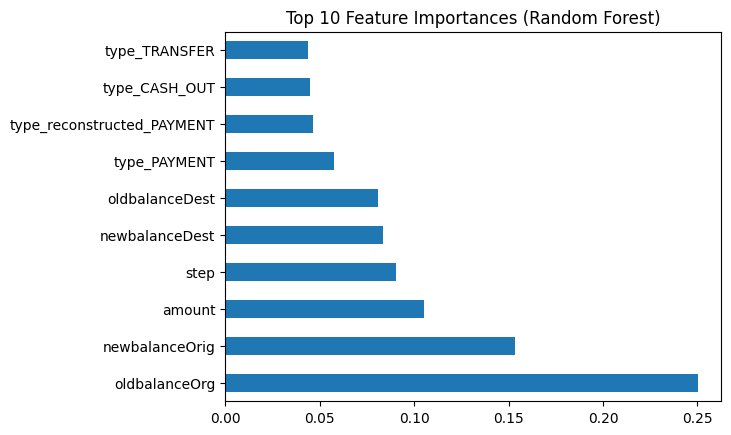

In [28]:
# Feature Importance for Random Forest
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train_sample.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()